# AWESim SOSS

**Analyzing Webb Exoplanet Simulations with SOSS**

In [1]:
# Magic functions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Imports
import numpy as np
import astropy.units as q
import matplotlib.pyplot as plt
import batman
from pkg_resources import resource_filename
from awesimsoss import awesim

## M Dwarf (no planet)

Here is how to generate time series observations of a brown dwarf (or any other isolated star with no transiting planet).

We need two components to generate this simulation:
- A flux calibrated stellar spectrum
- A specified number of integrations and groups for the observation

Let's use this 3500K stellar spectrum with a J magnitude of 9.

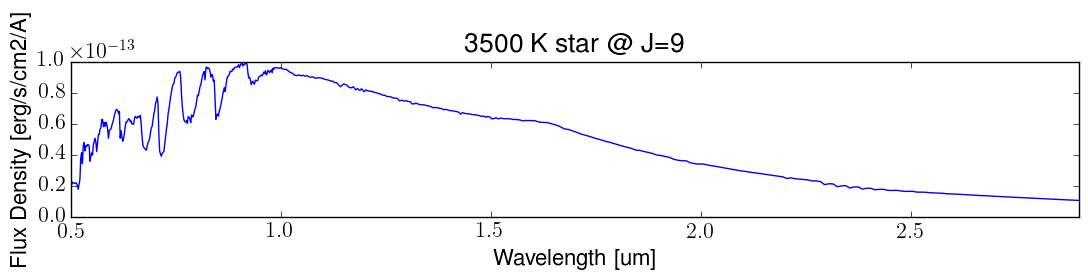

In [5]:
# Get the wavelength and flux of the star with units
star = np.genfromtxt(resource_filename('awesimsoss','files/scaled_spectrum.txt'), unpack=True)
star1D = [star[0]*q.um, (star[1]*q.W/q.m**2/q.um).to(q.erg/q.s/q.cm**2/q.AA)]

# Plot it 
plt.figure(figsize=(13,2));
plt.plot(*star1D);
plt.xlim(0.5,2.9);
plt.title('3500 K star @ J=9');
plt.ylabel('Flux Density [erg/s/cm2/A]');
plt.xlabel('Wavelength [um]');

Now we can intialize the silumation.

In [6]:
# Initialize the simulation
ngrps, nints = 3, 20
TSO1 = awesim.TSO(ngrps, nints, star1D)

And then run the simulation (this takes about 2 minutes)...

In [7]:
# Now run it
TSO1.run_simulation()

Calculating order 1 light curves...
Lightcurves finished: 72.69638395309448
Constructing order 1 traces...
Order 1 traces finished: 23.96999502182007
Calculating order 2 light curves...
Lightcurves finished: 69.95381116867065
Constructing order 2 traces...
Order 2 traces finished: 22.889045000076294
Adding noise to TSO...
Noise model finished: 7.941196918487549

Total time: 198.93113803863525


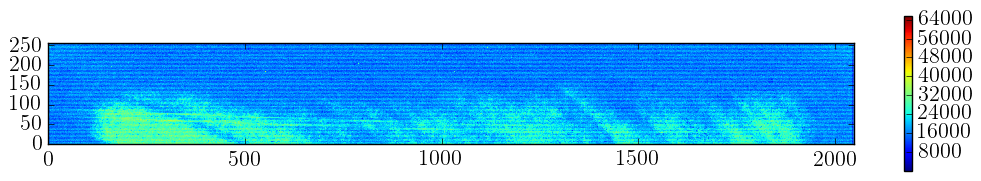

In [8]:
# Take a look
TSO1.plot_frame()

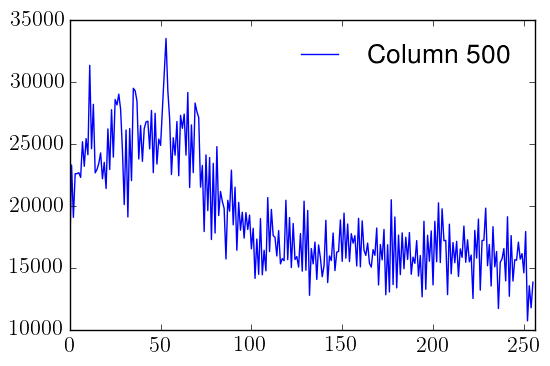

In [9]:
TSO1.plot_slice(500)

## M Dwarf (with planet)
Let's pretend this M dwarf is orbited by WASP107b! Why not? First get the transmission spectrum:

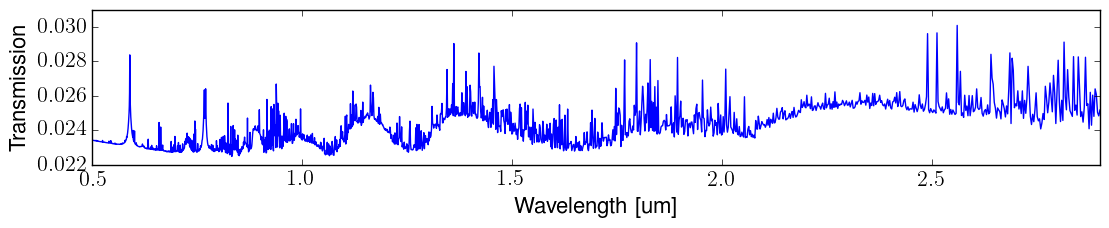

In [10]:
# Get the planet data
planet_file = resource_filename('awesimsoss', '/files/WASP107b_pandexo_input_spectrum.dat')
planet1D = np.genfromtxt(planet_file, unpack=True)

# Plot it 
plt.figure(figsize=(13,2));
plt.plot(*planet1D);
plt.xlim(0.5,2.9);
plt.ylabel('Transmission');
plt.xlabel('Wavelength [um]');

In [11]:
# Set the orbital params (https://www.cfa.harvard.edu/~lkreidberg/batman/quickstart.html)
params = batman.TransitParams()
params.t0 = 0.                  # Time of inferior conjunction
params.per = 1.                 # Orbital period
params.rp = 0.1                 # Planet radius (in units of R*)
params.a = 15.                  # Semi-major axis (in units of R*)
params.inc = 87.                # Orbital inclination (in degrees)
params.ecc = 0.                 # Eccentricity
params.w = 90.                  # Longitude of periastron (in degrees) 
params.u = [0.1, 0.1]           # Limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"  # Limb darkening model

# Make the transit model and add the stellar params
day2sec = 86400
tmodel = batman.TransitModel(params, TSO1.time/day2sec)
tmodel.teff = 3500              # Effective temperature of the host star
tmodel.logg = 5                 # log surface gravity of the host star
tmodel.feh = 0                  # Metallicity of the host star

In [12]:
# Run the simulation
TSO1.run_simulation(planet=planet1D, tmodel=tmodel)

Calculating order 1 light curves...
Lightcurves finished: 73.77587389945984
Constructing order 1 traces...
Order 1 traces finished: 24.34569811820984
Calculating order 2 light curves...
Lightcurves finished: 71.48880910873413
Constructing order 2 traces...
Order 2 traces finished: 23.10526394844055
Adding noise to TSO...
Noise model finished: 7.937477111816406

Total time: 202.07708621025085


100%|██████████| 5/5 [00:00<00:00, 75.44it/s]


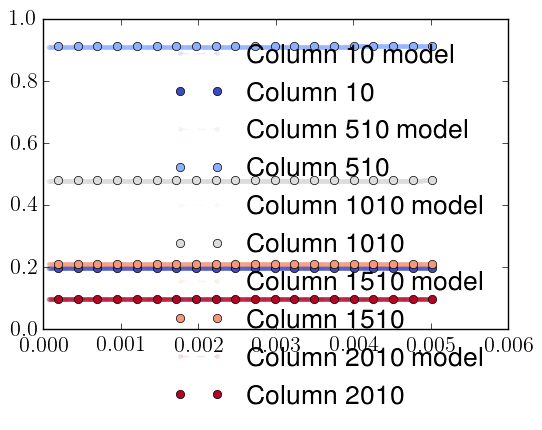

In [13]:
# Plot the lightcurve
TSO1.plot_lightcurve(column=range(10,2048,500))

Make your SOSS simulations, but remember... have fun.

100%|██████████| 1/1 [00:00<00:00, 25.04it/s]


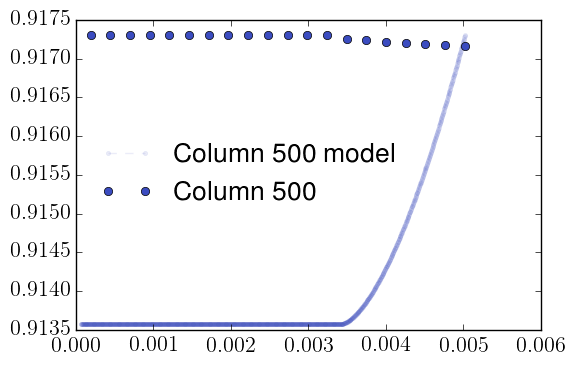

In [14]:
TSO1.plot_lightcurve(column=500)